In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy import signal
from pathlib import Path
import h5py
import utils
from mpl_markers import axis_marker
import sys
import utils

dir_ = Path.cwd()

%config InlineBackend.figure_formats = ['svg']
from IPython.display import HTML

# ECE 6961 Wireless Communications
## Project Part 2

Group Members: Grant Brown, Thomas Warren, Rick Lyon

Setup
---------

To generate this report and the associated plots:

1. Install Python 3.11.
2. Open a terminal window and navigate to the directory containing the project files. 
2. Create an virtual environment for the report/project. See [here](https://docs.python.org/3/library/venv.html) for more information.  
`> python -m venv .venv`
4. In the newly created environment, install the required packages from the requirements.txt file included with the project files.  
`(.venv) > pip install -r requirements.txt`
5. Open the report with Jupyter Notebooks.  
`(.venv) > jupyter notebook part2.ipynb`
6. The notebook should open in the default browser. 

7. To generate the .html version of the report,  
`(.venv) > jupyter nbconvert --to html part2.ipynb`

In [2]:
# parameters
K = 2048 # number of subcarriers
L = 200 # number of zero pad samples
Fc = 24e3 # carrier frequency
B = 8e3 # bandwidth
W = 24 # number of OFDM symbols
sps = 24 # samples per symbol
fs_rx = 256e3 # sampling rate of recieiver
fs_tx = 192e3
Ts_rx = 1 / fs_rx
Ts_tx = 1 / fs_tx

############################################
# load received dataset
f = h5py.File(dir_ / "data/benchmark_rece_data_174623_1472.mat",'r')
rxdata_raw = f["rece_data_ofdm_bench"][:].flatten()

# comp filter
f = loadmat(dir_ / "data/itc_1007_compfilter.mat")
comp_filter = f["h_comp"][:].flatten()

# get reference data
f = h5py.File(dir_ / "data/benchmark_parameter_174623_1472.mat",'r')
a_est_ref = f["a_est_174623"][:].flatten()
eps_ref = f["Epsil_Point_174623"][:]
n0_ref = f["START_at_beginning_174623"][:]

n0_1_ref = f["Start_Point_174623"][:]

f = h5py.File(dir_ / "data/benchmark_Zw_174623_1472.mat")
z_ref = f["bb_rece_data_174623"][:]
z_ref = z_ref["real"] + 1j * z_ref["imag"]

# reference zw includes the prefix, remove last 200 samples
z_ref = z_ref[:, :-L]

# get the null subcarrier index
f = h5py.File(dir_ / "data/ofdm_map.mat",'r')
null_subcarrier = f["ofdm_map"][:].flatten()
null_idx = np.argwhere(null_subcarrier == 0).squeeze()

# pilot signal used to find the beginning of the data
f = loadmat(dir_ / r"data/pilot_signal_for_synchronization.mat")
pilot_signal = f["OFDM_data_pre_old"][:].flatten()
########################################

## Bandpass Filter

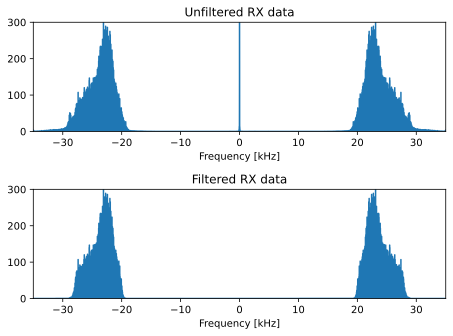

In [3]:
fig, (ax1, ax2) = plt.subplots(2,1)

# sampling rate of receiver is 256e3
utils.plot_fft(rxdata_raw, fs_rx, ax=ax1)
ax1.set_title("Unfiltered RX data")
ax1.set_xlim([-35, 35])
ax1.set_ylim([0, 300])

# bandpass filter 
sos = signal.butter(20, (Fc-4e3, Fc+4e3), btype="band", output="sos", fs=fs_rx)
Ypb = signal.sosfilt(sos, rxdata_raw)
utils.plot_fft(Ypb, fs_rx, ax=ax2)
ax2.set_title("Filtered RX data")
ax2.set_xlim([-35, 35])
ax2.set_ylim([0, 300])

plt.tight_layout()

## Correlate with Chirp Signal

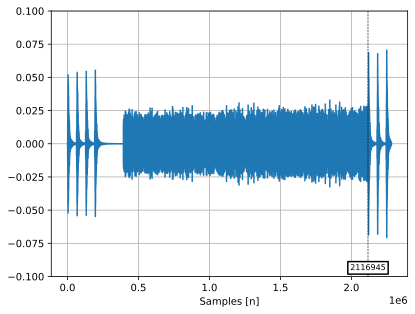

In [4]:
# correlate last half of signal with three chirps
Y_chirp = Ypb[:int(0.75*fs_rx)]

chirp_corr_start = int(len(Ypb)/2)
chirp_corr = signal.correlate(Ypb[chirp_corr_start:], Y_chirp, mode="same")

# get the index of the start of the chirps at the end of the signal
chirp_i_1 = np.argmax(np.abs(chirp_corr)) - (len(Y_chirp) /2) + chirp_corr_start

plt.figure()
plt.plot(Ypb)
m = axis_marker(chirp_i_1, xformatter=lambda x: "{:.0f}".format(x))
plt.xlabel("Samples [n]")
plt.ylim([-0.1, 0.1])
plt.grid()
plt.show()

## Estimate $\tilde{a}$

In [5]:
# time between three chirps is 0.75 (0.05 for chirp plus 0.2 silence for each chirp).
# at the receiver there are 191900 samples between each
# T_signal_rx = #191900 * Ts_rx
T_signal = 8.2695 # length of TX data signal + the preamble in time
T_signal_rx = (chirp_i_1) * Ts_rx # length of the RX data up to the ending chirps
a_est = (T_signal / T_signal_rx) - 1

print(f"a_est = {a_est:.2e}")
# a_est = a_est_ref

a_est = 2.22e-05


## Resampling to remove Doppler shift

In [6]:
# resampling to remove the doppler shift, equation 7 in the paper. Since
# a is positive, the rx signal is compressed from the tx signal, and this resampling
# will stretch it out.
Ypb_re = signal.resample_poly(Ypb, np.around((1 + a_est) * 1e5), 1e5)

# resample the RX data to 192kHz so it's the same as the transmitter
Ls = 192
Ms = 256
Nfir = Ls * Ls - 1
wnd = signal.get_window(('kaiser', 7.8562), Nfir+1)
h = Ls * signal.firwin(Nfir, 1/Ms, window=('kaiser', 7.8562))
Ypb_re_txs = signal.upfirdn(h, Ypb_re, Ls, Ms)

## Correlate with Pilot Signal

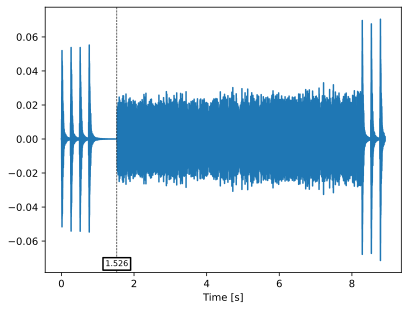

In [7]:
# correlate with pilot signal to get data starting point.
# skip the preamble, which is 1 second
n_start = int(fs_tx * 1)
# only correlate with first 0.75s of signal
n_stop = n_start + int(fs_tx * 0.75)
pilot_corr = signal.correlate(Ypb_re_txs, pilot_signal, mode='valid')

# use the peak of the correlation to extract the data part of the RX signal
n0 = np.argmax(pilot_corr) + 70

plt.figure()
plt.plot(np.arange(len(Ypb_re_txs)) * Ts_tx, Ypb_re_txs)
plt.xlabel("Time [s]")
axis_marker(n0 * Ts_tx)

## Predistortion Filter

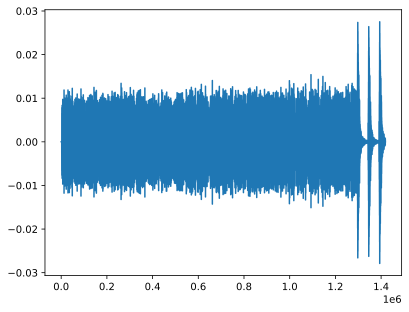

In [8]:
Ypb = np.convolve(Ypb_re_txs[n0:], comp_filter)[50:]

plt.plot(Ypb)

## Passband to Baseband

<Axes: xlabel='Frequency [kHz]'>

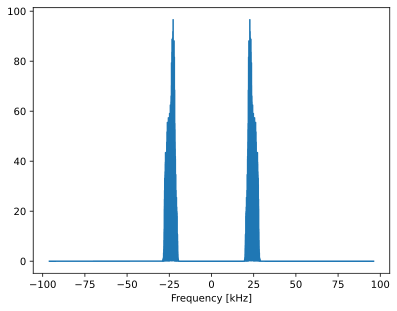

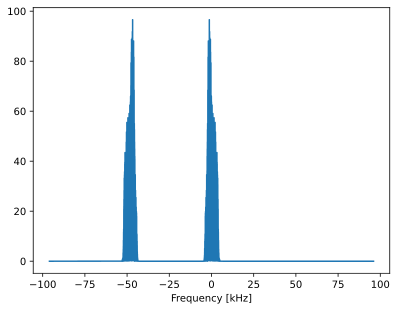

In [9]:
utils.plot_fft(Ypb, fs_tx)

n = np.arange(0, len(Ypb))
Ybb = Ypb * np.exp(-1j * Fc * 2* np.pi * n * Ts_tx)

utils.plot_fft(Ybb, fs_tx)

## Matched Filter

(-10.0, 10.0)

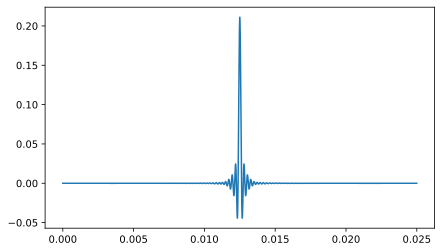

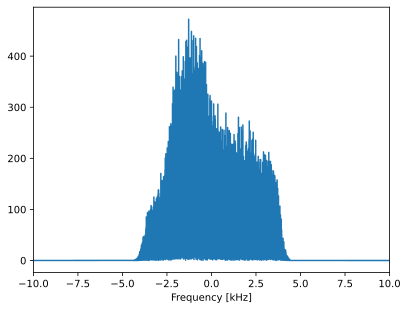

In [10]:
beta = 0.125 # roll off factor
n = np.arange(-sps*100, sps*100) 
t = np.arange(len(n)) * Ts_tx
R = utils.srrc_pulse(n, sps, beta)

fig, ax = plt.subplots(1,1, figsize=(7, 4))
ax.plot(t, R)

Ybb_f = np.convolve(Ybb, R)

# remove the delay caused by filter
delay_s = (100 * sps)
Ybb_f = Ybb_f[delay_s:-delay_s]

utils.plot_fft(Ybb_f, fs_tx)
plt.xlim([-10, 10])


## Doppler Resampling and Carrier Frequency Compensation

In [11]:

def apply_cfo_vectorized(data, eps_vec, n0_vec):
    
    data_ds = np.zeros((len(n0_vec), (K+L-1)), dtype='complex128')
    n_sample_vec = np.zeros((len(n0_vec), (K+L-1)))
    # downsample the data to the 8k data rate, at each starting n0 point
    for i, n0_i in enumerate(n0_vec):
        data_ds[i] = data[n0_i:n0_i+(K+L-1)*sps:sps] 
    
        # cfo compensation exponential, vectorized over each eps value in the grid along the rows
        n_sample_vec[i] = np.arange(n0_i, n0_i+(K+L-1)*sps, sps)

    # CFO vector, shape is eps_vec, n0_vec, K+L-1
    cfo = np.exp(-1j * 2 * np.pi * eps_vec[..., None, None] * n_sample_vec[None] * Ts_tx)

    # apply the cfo compensation
    data_cfo = data_ds[None] * cfo

    # create modified DFT matrix (overlap add)
    k, m = np.meshgrid(np.arange(K+L-1), np.arange(K))
    Gm = np.exp(-1j * 2*np.pi * m * k / K)

    # apply DFT with matrix multiplication
    Zm = np.einsum("ij,...j->...i", Gm, data_cfo)

    # sum the power in the null subcarriers
    Pnull = np.sum(np.abs(Zm[..., null_idx])**2, axis=-1)

    # get the index of the minimum power
    eps_min_i, n0_min_i = np.unravel_index(np.argmin(Pnull), Pnull.shape)
    # return the eps with the lowest null power, and the null power for that eps
    return eps_vec[eps_min_i], int(n0_vec[n0_min_i]), Pnull[eps_min_i, n0_min_i]

n0_vec = np.arange(2300, 2600, 10)
eps_vec = np.arange(-1, 1.1, 0.1)
w0_eps0, w0_n0, min_pwr0 = apply_cfo_vectorized(Ybb_f, eps_vec, n0_vec)

print(f"OFDM Symbol 1: eps={w0_eps0:.2f}, n0={w0_n0}, Null Power={min_pwr0:.2f}")

OFDM Symbol 1: eps=0.20, n0=2300, Null Power=0.22


In [12]:
sym_n0 = np.zeros(W-2)
sym_eps = np.zeros(W-2)
min_pwr0 = np.zeros(W-2)
sym_n0[0] = w0_n0

for w in range(1, W-2):
    n0_w = int(sym_n0[w-1]) + ((K + L -1) * sps)
    n0_vec = np.arange(n0_w - (2 * sps), n0_w + (2 * sps), 2)
    eps_vec = np.arange(-1, 1.1, 0.1)
    sym_eps[w], sym_n0[w], min_pwr0[w] = apply_cfo_vectorized(Ybb_f, eps_vec, n0_vec)


    sys.stdout.write(f"\rSymbol {w+1}/21: eps={sym_eps[w]:.2f}, n0={int(sym_n0[w])}, Null Power={min_pwr0[w]:.2f}\t\t\t\t\t\t")


Symbol 22/21: eps=-0.00, n0=1135118, Null Power=0.22						

In [13]:
n0_1_ref

array([[   2300.],
       [  56300.],
       [ 110235.],
       [ 164206.],
       [ 218110.],
       [ 272086.],
       [ 326018.],
       [ 380018.],
       [ 434011.],
       [ 487994.],
       [ 541940.],
       [ 595844.],
       [ 649783.],
       [ 703769.],
       [ 757766.],
       [ 811758.],
       [ 865708.],
       [ 919708.],
       [ 973613.],
       [1027566.],
       [1081485.]])

In [14]:
sym_n0

array([   2300.,   56258.,  110158.,  164132.,  218024.,  271956.,
        325862.,  379742.,  433622.,  487596.,  541568.,  595532.,
        649502.,  703402.,  757364.,  811326.,  865298.,  919272.,
        973246., 1027220., 1081162., 1135118.])

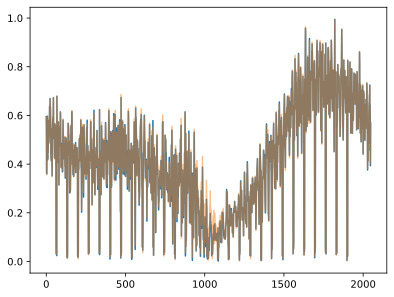

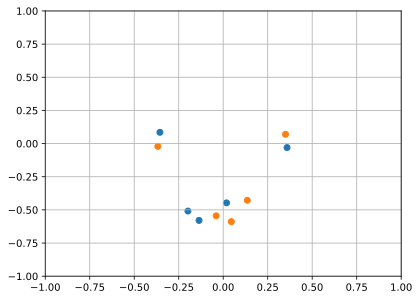

In [15]:
def apply_cfo(data, n0_i, eps_j):
    n_vec = np.arange(n0_i, n0_i+(K+L-1)*sps, 1)
    data_cfo = data[n0_i:n0_i+(K+L-1)*sps] * np.exp(-1j * 2 * np.pi * eps_j * n_vec * Ts_tx)

    # downsample to the data rate (8k)
    y_m = data_cfo[::sps]

    # create modified DFT matrix (overlap add)
    k, m = np.meshgrid(np.arange(K+L-1), np.arange(K))
    Gm = np.exp(-1j * 2*np.pi * m * k / K)
    # apply DFT with matrix multiplication
    Zm = np.einsum("ij,j->i", Gm, y_m)

    return Zm

Zm0 = apply_cfo(Ybb_f, w0_n0, w0_eps0)

plt.figure()
plt.plot(np.abs(Zm0))
plt.plot(np.abs(z_ref[0]), alpha=0.5)

plt.figure()
plt.scatter(np.real(Zm0[:5]), np.imag(Zm0[:5]))
plt.scatter(np.real(z_ref[0,:5]), np.imag(z_ref[0,:5]))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)



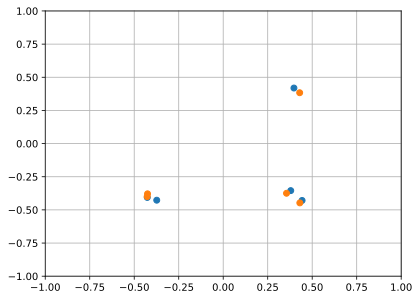

In [16]:
Zm_total = apply_cfo(Ybb_f, int(sym_n0[12]), sym_eps[12])

plt.figure()
plt.scatter(np.real(Zm_total[:5]), np.imag(Zm_total[:5]))
plt.scatter(np.real(z_ref[12,:5]), np.imag(z_ref[12,:5]))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)